In [2]:
import pandas as pd

df = pd.read_csv('data/adult.csv', header=None)


In [3]:
from sklearn.model_selection import train_test_split

random_state = 42

def apply_col_names(df: pd.DataFrame):

    col_names = ['age', 'workclass', 'fnlwgt', 'education',
    'education_num', 'Marital status', 'occupation',
    'relationship', 'race', 'sex', 'capitalgain',
    'capitalloss', 'hoursperweek', 'native', 'Salary']

    df.columns = col_names

    return df


In [4]:
from sklearn.preprocessing import OneHotEncoder, RobustScaler

def transform_categorical(df: pd.DataFrame):

    df['workclass'].fillna(df['workclass'].mode()[0], inplace=True)

    df_categorical = df.select_dtypes(include='object')
    print(f'There are {len(df_categorical.columns)} categorical columns.')

    df_non_categorical = df[[col for col in df.columns 
                                if col not in df_categorical.columns]]
    ohe = OneHotEncoder(sparse=False)
    scaler = RobustScaler()
    encoded_array = ohe.fit_transform(df_categorical)
    one_hot_encoded_data = pd.DataFrame(encoded_array, columns=ohe.get_feature_names_out())

    df_non_categorical[df_non_categorical.columns] = scaler.fit_transform(df_non_categorical)
    processed_data = pd.concat([df_non_categorical, one_hot_encoded_data], axis=1)
    Y: pd.Series = [el.strip() == '>50K' for el in df['Salary']]
    print(f'{Y=}')
    X: pd.DataFrame = processed_data[processed_data.columns.difference(['Salary'])]

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=random_state, test_size=0.2)
    return X_train, X_test, Y_train, Y_test

Now lets transform our data.

In [5]:
preprocessed_df = apply_col_names(df)
X_train, X_test, Y_train, Y_test = transform_categorical(preprocessed_df)

There are 9 categorical columns.
Y=[False, False, False, False, False, False, False, True, True, True, True, True, False, False, True, False, False, False, False, True, True, False, False, False, False, True, False, True, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, True, False, False, False, False, False, False, True, True, False, True, False, False, False, False, False, False, False, True, False, False, False, True, True, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, True, False, True, False, False, True, False, False, False, False, True, False, True, True, False, False, True, True, False, False, False, True, False, False, False, False, False, True, True, False, False, False, False, True, False, False, False, False, False, True, False, True, False, True, False, False, False, False, False, False, False, True, False, False, False, True, False, False, False,

/Users/alejandro/Programming/Courses/EEC189G-Spring23/HW3/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/var/folders/bh/79ms89214n70lb56qjzk005c0000gn/T/ipykernel_34712/3477549269.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_categorical[df_non_categorical.columns] = scaler.fit_transform(df_non_categorical)


accuracy: 0.998
precision: 0.993
recall: 1.000
f1: 0.997
y_pred_prob=array([1.65633891e-14, 3.70558009e-08, 1.00000000e+00, ...,
       1.00000000e+00, 8.08337724e-14, 4.48586224e-16])
fpr=array([0.        , 0.00222582, 1.        ])
tpr=array([0., 1., 1.])


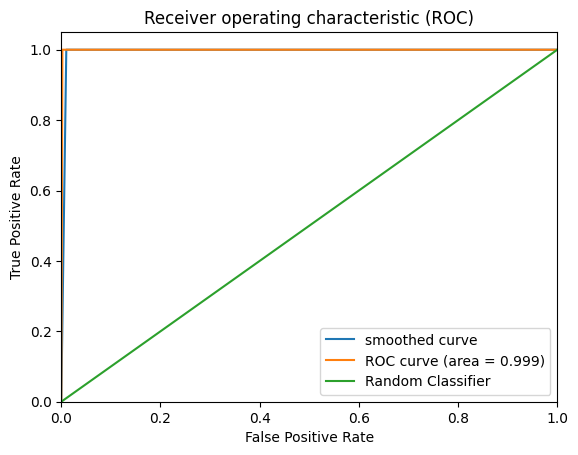

True Negatives: 4931, False Positives: 11, False Negatives: 0, True Positives: 1571


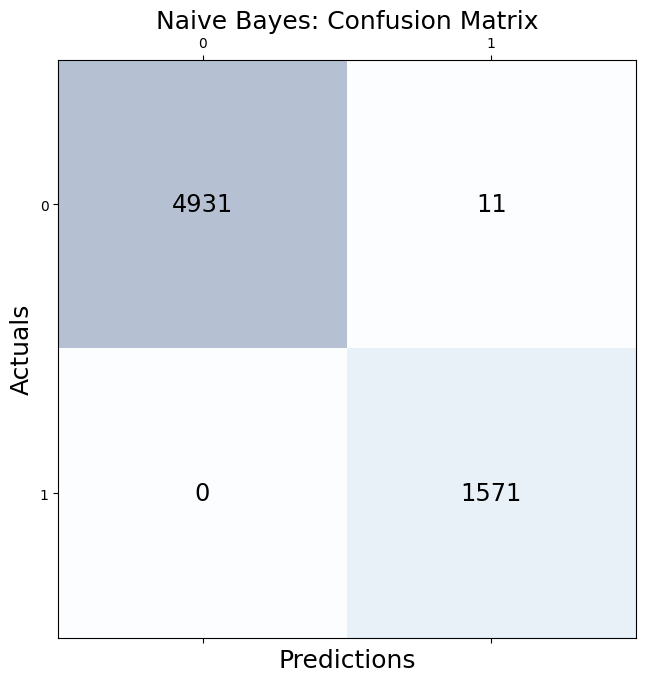

In [7]:
import matplotlib.pyplot as plt

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc


metric_list = {'accuracy': accuracy_score, 'precision': precision_score, 'recall': recall_score, 'f1': f1_score}


gnb = GaussianNB()


gnb.fit(X_train, Y_train)

y_pred = gnb.predict(X_test)
for name, metric in metric_list.items():
    print(f'{name}: {metric(Y_test, y_pred):.3f}')


y_pred_prob = gnb.predict_proba(X_test)[:,1]

print(f'{y_pred_prob=}')

fpr, tpr, _ = roc_curve(Y_test, y_pred, drop_intermediate=False)

roc_auc = auc(fpr, tpr)

print(f'{fpr=}')
print(f'{tpr=}')

from scipy.interpolate import interp1d
import numpy as np

f = interp1d(fpr, tpr)
xnew = np.linspace(0, 1, num=100)

ynew = f(xnew)
plt.plot(xnew, ynew, label='smoothed curve')
plt.plot(fpr, tpr, label= f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()



tn, fp, fn, tp = confusion_matrix(Y_test, y_pred).ravel()
print(f'True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}, True Positives: {tp}')


fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(confusion_matrix(Y_test, y_pred), cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_matrix(Y_test, y_pred).shape[0]):
    for j in range(confusion_matrix(Y_test, y_pred).shape[1]):
        ax.text(x=j, y=i,s=confusion_matrix(Y_test, y_pred)[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Naive Bayes: Confusion Matrix', fontsize=18)
plt.show()

